<a href="https://colab.research.google.com/github/jeekyung/ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C_ch2_6_pg_132~145.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **06 사이킷런으로 수행하는 타이타닉 생존자 예측**

---

Passengerid: 탑승자 데이터 일련번호

survived: 생존 여부, 0=사망, 1=생존

pclass: 티켓의 선실 등급, 1=일등석, 2=이등석, 3=삼등석

sex: 탑승자 성별

name: 탑승자 이름

Age: 탑승자 나이

sibsp: 같이 탑승한 형제자매 또는 배우자 인원수

parch: 같이 탑승한 부모님 또는 어린이 인원수

ticket: 티켓 번호

fare: 요금

cabin: 선실 번호

embarked: 중간 정착 항구 C=Cherbourg, Q=Queenstown, S=Southamptom

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
titanic_df = pd.read_csv('/content/drive/MyDrive/titanic_train.csv')
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [6]:
#데이터 칼럼 타입 확인
print('\n ### 학습 데이터 정보 ### \n')
print(titanic_df.info())


 ### 학습 데이터 정보 ### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


사이킷런 머신러닝 알고리즘은 Null 값을 허용하지 않으므로 Null 값 처리-<u>fillna()</u> 이용

In [9]:
titanic_df['Age'].fillna(titanic_df['Age'].mean(),inplace=True)     #평균나이로 변경
titanic_df['Cabin'].fillna('N',inplace=True)
titanic_df['Embarked'].fillna('N',inplace=True)
print('데이터 세트 Null 값 개수', titanic_df.isnull().sum().sum())

데이터 세트 Null 값 개수 0


In [11]:
#남아있는 문자열 피처인 Sex,Cabin,Embarked 값 분류
print('Sex 값 분포 :\n',titanic_df['Sex'].value_counts())
print('\n Cabin 값 분포 :\n',titanic_df['Cabin'].value_counts())
print('\n Embarked 값 분포 :\n',titanic_df['Embarked'].value_counts())

Sex 값 분포 :
 male      577
female    314
Name: Sex, dtype: int64

 Cabin 값 분포 :
 N              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64

 Embarked 값 분포 :
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


Cabin(선실)-N이 687건 - 속성값이 제대로 정리되지 않음

In [12]:
#Cabin 속성의 앞 문자만 추출
titanic_df['Cabin']=titanic_df['Cabin'].str[:1]
print(titanic_df['Cabin'].head(3))

0    N
1    C
2    N
Name: Cabin, dtype: object


**1] 어떤 유형의 승객이 생존 확률이 높았는가**

-여성, 아이들, 노약자, 부자, 유명인 순으로 구조 예상

In [14]:
#성별에 따른 생존자 수 비교
titanic_df.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

->여성은 76.2% 생존, 남성은 18.8% 생존

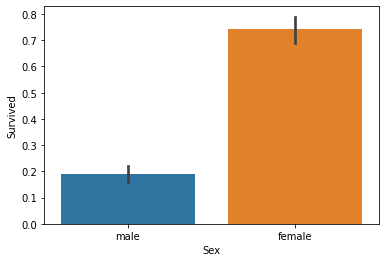

In [16]:
#시각화
sns.barplot(x='Sex',y='Survived',data=titanic_df)

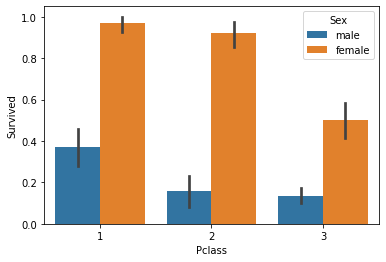

In [17]:
#부에 따른 생존확률 비교
#객실 등급 이용
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)       #성별로 색상 구분

->여성: 삼등실 생존확률 상대적으로 많이 떨어짐
->남성: 일등실 생존확률 상대적으로 매우 높음

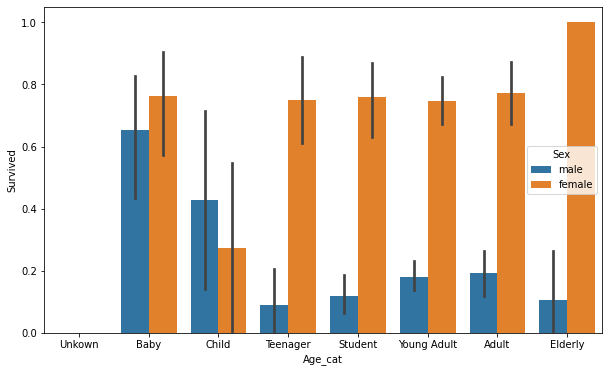

In [20]:
#Age에 따른 생존확률 비교
#값 종류가 많아 범위 별로 카테고리 값 할당
#입력 age에 따라 구분 값ㅇ르 반확하는 함수 설정. DataFrame의 apply lambda 식에 사용
def get_category(age):
  cat=''
  if age <= -1: cat = 'Unknown'
  elif age <= 5: cat = 'Baby'
  elif age <= 12: cat = 'Child'
  elif age<= 18: cat = 'Teenager'
  elif age<= 25: cat = 'Student'
  elif age<= 35: cat = 'Young Adult'
  elif age<= 60: cat = 'Adult'
  else: cat = 'Elderly'

  return cat

#막대그래프의 크기 figure를 더 크게 설정
plt.figure(figsize=(10,6))

#X축의 값을 순차적으로 표시하기 위한 설정
group_names = ['Unkown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

#lambda 식에 위에서 생성한 get_category() 함수를 반환값을 ㅗ지정
#get_category(X)는 입력값으로 'Age' 칼럼 값을 받아서 해당하는 cat 반환
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x))
sns.barplot(x='Age_cat', y='Survived', hue='Sex', data=titanic_df,order=group_names)
titanic_df.drop('Age_cat', axis=1, inplace=True)

->여자 child는 다른 연령대에 비해 생존 확률 낮음

=Sex, Age, Pclass 등이 중요하게 생존을 좌우하는 피처다.

남아있는 문자열 카테고리 피처를 숫자형 카테고리 피처로 변환

LabelEncoder 클래스 이용해 레이블 인코딩 적용

LabelEncoder 객체: 카테고리 값의 유형 수에 따라 0~ (카테고리 유형 수-1)까지의 숫자 값으로 변환

In [23]:
from sklearn import preprocessing

def encode_features(dataDF):     #여러 칼럼 한 번에 변환 위해 함수 생성
  features = ['Cabin','Sex', 'Embarked']
  for feature in features:
    le = preprocessing.LabelEncoder()
    le = le.fit(dataDF[feature])
    dataDF[feature] = le.transform(dataDF[feature])
  
  return dataDF

titanic_df = encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


지금까지 피처를 가공한 내역을 정리하고 이를 함수로 만들어 쉽게 재사용 가능하도록 만들기

데이터의 전처리를 전체적으로 호출하는 함수는 **transform_features()**이고,

Null 처리, 포매팅, 인코딩을 수행하는 내부 함수로 구성

In [34]:
from sklearn import preprocessing

#Null 처리 함수
def fillna(df):
  df['Age'].fillna(df['Age'].mean(), inplace=True)
  df['Cabin'].fillna('N',inplace=True)
  df['Embarked'].fillna('N',inplace=True)
  df['Fare'].fillna(0,inplace=True)
  return df


#머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
  df.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)
  return df


#레이블 인코딩 수행
def format_features(df):
  df['Cabin'] = df['Cabin'].str[:1]
  features = ['Cabin', 'Sex', 'Embarked']
  for feature in features:
    le = preprocessing.LabelEncoder()
    le=le.fit(df[feature])
    df[feature] = le.transform(df[feature])
  return df


#앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
  df=fillna(df)
  df = drop_features(df)
  df=format_features(df)
  return df

위 함수를 이용해 원본 데이터 가공해보기

원본 CSV파일을 다시 로딩하고 타이타닉 생존자 데이터 세트의 레이블인 Survived 속성만 별도 분리해 클래스 결정값 데이터 세트로 만들기

이후 Survived 속성을 드롭해 피처 데이터 세트 생성

이렇게 생성된 피처 데이터 세트에 transform_features() 적용해 데이터 가공

In [35]:
#원본 데이터를 재로딩하고, 피처 데이터 세트와 레이블 데이터 세트 추출
titanic_df = pd.read_csv('/content/drive/MyDrive/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)

X_titanic_df = transform_features(X_titanic_df)

In [36]:
#내려받은 학습 데이터 세트를 기반으로 train_test_split() API를 이용해 별도의 테스트 데이터 세트 추출
#테스트 데이터 세트 크기는 전체의 20% 설정
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state=11)

**ML 알고리즘인 결정 트리, 랜덤 포레스트, 로지스틱 회귀를 이용해 타이타닉 생존자 예측하기**

결정트리-DecisionTreeClassifier 클래스 제공

랜덤포레스트-RandomForestClassifier 클래스 제공

로지스틱 회귀-LogisticRegression 클래스 제공

이들을 이용해 train_test-split()으로 분리한 학습 데이터와 테스트 데이터를 기반으로 멋니러닝 모델을 학습(fit), 예측(predict) 할 것

예측 성능 평가는 정확도로 할것이며 accuracy_score() API 사용

-DecisionTreeClassifier와 RandomForestClassifier에서 random_state=11은 예제를 수행할 때마다 같은 결과를 출력하기 위한 용도이니 실제 사례에서는 제거해도 된다.

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#결정트리, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

#DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train,y_train)
dt_pred=dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:4f}'.format(accuracy_score(y_test,dt_pred)))

#RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train,y_train)
rf_pred=rf_clf.predict(X_test)
print('RandomForestClassifier 정확도: {0:4f}'.format(accuracy_score(y_test,rf_pred)))

#LogisticRegression 학습/예측/평가
lr_clf.fit(X_train,y_train)
lr_pred=lr_clf.predict(X_test)
print('LogisticRegression 정확도: {0:4f}'.format(accuracy_score(y_test,lr_pred)))

DecisionTreeClassifier 정확도: 0.787709
RandomForestClassifier 정확도: 0.854749
LogisticRegression 정확도: 0.849162


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


3개의 알고리즘 중 LogisticRegression이 타 알고리즘에 비해 높은 정확도.

아직 최적화 작업을 수행하지 않았고 데이터 양도 충분하지 않기 때문에 어떤 알고리즘이 가장 성능이 좋다고 평가 불가

**교차 검증으로 결정 트리 모델 평가**

KFold, cross_val_score(), GridSearchCV 클래스 모두 사용

**1) KFold 클래스를 이용**해 교차 검증을 수행하며, 폴드 개수는 5개로 설정

In [38]:
from sklearn.model_selection import KFold

def exec_kfold(clf,folds=5):
  #폴드 세트를 5개인 KFold 객체를 생성, 폴드 수만큼 예측결과 저장을 위한 리스트 객체 생성
  kfold=KFold(n_splits=folds)
  scores=[]

  #KFold 교차 검증 수행
  for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
    #X_titanic_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
    X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
    y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
    #Classifier 학습, 예측, 정확도 계산
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    scores.append(accuracy)
    print("교차 검증 {0} 정확도: {1:4f}".format(iter_count, accuracy))

  #5개 fold에서의 평균 정확도 계산
  mean_score = np.mean(scores)
  print("평균 정확도: {0:4f}". format(mean_score))

#exec_kfold 호출
exec_kfold(dt_clf,folds=5)

교차 검증 0 정확도: 0.754190
교차 검증 1 정확도: 0.780899
교차 검증 2 정확도: 0.786517
교차 검증 3 정확도: 0.769663
교차 검증 4 정확도: 0.820225
평균 정확도: 0.782299


**2) cross_val_score API 이용**

In [40]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf,X_titanic_df, y_titanic_df, cv=5)
for iter_count, accuracy in enumerate(scores):
  print("교차 검증{0} 정확도: {1:4f}".format(iter_count,accuracy))

print("평균 정확도: {0:4f}".format(np.mean(scores)))

교차 검증0 정확도: 0.743017
교차 검증1 정확도: 0.775281
교차 검증2 정확도: 0.792135
교차 검증3 정확도: 0.786517
교차 검증4 정확도: 0.842697
평균 정확도: 0.787929


cross_val_score()와 이전의 K 폴드의 평균 정확도의 차이 존재

=cross_val_score()가 StratifiedKFold를 이용해 폴드 세트를 분할하기 떄문

**3) GridSearchCV 이용**

DecisionTreeClassifier의 최적 하이퍼 파라미터 찾고 예측 성능 측정

CV는 5개의 폴드 세트 지정, 하이퍼 파라미터는 max_depth, min_samples_split, min_samples_leaf를 변경하며 성능 측정

최적 하피어 파라미터와 그떄의 예측을 출력하고, 최적 하이퍼 파라미터로 학습된 Estimator를 이용해 위의 train_test_split()으로 분리된 테스트 데이터 세트에 예측을 수행해 예측 정확도 출력

In [41]:
from sklearn.model_selection import GridSearchCV

parameters={'max_depth':[2,3,5,10],'min_samples_split':[2,3,5],'min_samples_leaf':[1,5,8]}

grid_dclf=GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy',cv=5)
grid_dclf.fit(X_train, y_train)

print('GridSearchCV 최적 하이퍼 파라미터:',grid_dclf.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dclf.best_score_))
best_dclf=grid_dclf.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행
dpredictions=best_dclf.predict(X_test)
accuracy=accuracy_score(y_test, dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy))

GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.7992
테스트 세트에서의 DecisionTreeClassifier 정확도: 0.8715


최적화된 하이퍼 파라미터인 max_depth=3, min_samples_leaf=1, min_samples_split=2로 예측 정확도가 약 87.15%로 향상됨